# Rock Detection with Sonar (KNN)



## The Sonar Data 

### Detecting a Rock or a Mine

Sonar (sound navigation ranging) is a technique that uses sound propagation (usually underwater, as in submarine navigation) to navigate, communicate with or detect objects on or under the surface of the water, such as other vessels.

<img src="sonar.jpg"  style="max-height: 500px; max-width: 500px;">

The data set contains the response metrics for 60 separate sonar frequencies sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at (either a rock or a mine). 

<img src="mine.jpg"  style="max-height: 500px; max-width: 500px;">

The main goal is to create a machine learning model capable of detecting the difference between a rock or a mine based on the response of the 60 separate sonar frequencies.


Data Source: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../DATA/sonar.all-data.csv')

In [3]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Data Exploration

<AxesSubplot:>

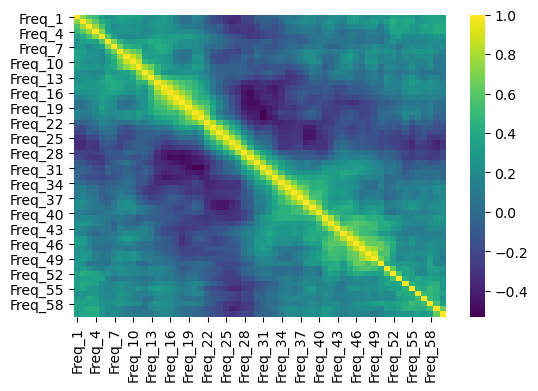

In [4]:
# Visualizing the dataset with a heatmap

# We can observe that there are dark patches indicating that some feature interpolation is possible from the data

plt.figure(dpi=100)
sns.heatmap(df.corr(),cmap='viridis')

**Take a look at the top 10 correlated frequencies with the target\label**

In [38]:
# Add Target column representing R and M to 0 and 1 respectively

df['Target'] = df ['Label'].map({'R':0,'M':1}) #.corr()#['Label']#.abs()#.sort_values(ascending=False)#-5:]

In [53]:
# Check that is added correctly

df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label,Target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R,0


In [40]:
# Calculate correlation to Target column and sort for the 10 highest correlated frequencies

df.corr().abs()['Target'].sort_values(ascending=False)[:11]

Target     1.000000
Freq_11    0.432855
Freq_12    0.392245
Freq_49    0.351312
Freq_10    0.341142
Freq_45    0.339406
Freq_48    0.329333
Freq_9     0.321448
Freq_13    0.312811
Freq_46    0.305610
Freq_47    0.301697
Name: Target, dtype: float64

# 

## Train | Test Split

I will use Cross Validation on 90% of the dataset, and then evaluate the model on a final test set of 10%.


In [54]:
from sklearn.model_selection import train_test_split

X = df.drop('Label',axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**PipeLine that contains both a StandardScaler and a KNN model**

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
knn = KNeighborsClassifier()
operations = [('scaler',scaler),('knn',knn)]
pipe = Pipeline(operations) #in this pipeline, it would both scale and model the data

In [67]:
# setting up values for parameters that would go into the model (inside the pipeline ops)

k_values = list(range(1,30))
param_grid = {'knn__n_neighbors': k_values} #setup the params to use while conducting model gridsearch #always follow format
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [68]:
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [69]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

**Plot of the mean test scores per K value.**

In [48]:
#full_cv_classifier.cv_results_

In [70]:
# Select from the parameter cv results - mean_test_score

full_cv_classifier.cv_results_['mean_test_score'] 

array([0.92532006, 0.81280228, 0.84523471, 0.80768137, 0.84025605,
       0.81294452, 0.82944523, 0.80227596, 0.81322902, 0.79687055,
       0.82930299, 0.78634424, 0.83485064, 0.79743954, 0.80782361,
       0.80241821, 0.82375533, 0.80241821, 0.80782361, 0.78648649,
       0.80782361, 0.79231863, 0.79743954, 0.78150782, 0.77055477,
       0.7544808 , 0.77596017, 0.77055477, 0.8027027 ])

In [71]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

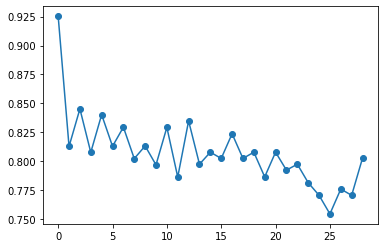

In [72]:
# Plot model cv results

# Model might be overfitting to the data. Hyperparamaters should be tuned

plt.plot(full_cv_classifier.cv_results_['mean_test_score'],marker='o')

### Final Model Evaluation

**Classification report and confusion matrix.**

In [73]:
y_pred = full_cv_classifier.predict(X_test)

In [74]:
y_pred

array(['M', 'R', 'R', 'R', 'M', 'R', 'M', 'M', 'R', 'R', 'M', 'R', 'M',
       'M', 'M', 'M', 'M', 'M', 'R', 'R', 'M'], dtype=object)

In [75]:
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           M       1.00      0.92      0.96        13
           R       0.89      1.00      0.94         8

    accuracy                           0.95        21
   macro avg       0.94      0.96      0.95        21
weighted avg       0.96      0.95      0.95        21



In [76]:
confusion_matrix(y_test,y_pred)

array([[12,  1],
       [ 0,  8]], dtype=int64)

### Model seems to be doing a good job at predicting Rocks from Mines. Due to how accurate it is, might be a good idea to test it out on fresh data to confirm model prediction validity.